In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import re
from src import utils, nlp_utils
from bs4 import BeautifulSoup

import nltk
from nltk.corpus import stopwords

from datetime import datetime

#nltk.download('wordnet')

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\morga\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


# Topical Modeling - Wall Street Market

## Data Processing

In [2]:
wallstreet = pd.read_csv('data/wallstreet.csv')
wall_nlp = wallstreet[['subforum', 'contentWithHTMLTag']].copy()

In [3]:
wall_nlp['cleaned_content'] = wall_nlp['contentWithHTMLTag'].apply(lambda x: nlp_utils.clean_parse_text(x))
wall_nlp['lemmatized_tokens'] = wall_nlp['contentWithHTMLTag'].apply(lambda x: nlp_utils.clean_tokenize_lemmatize(x))

In [4]:
wall_nlp.to_csv('data/wall_nlp.csv', index=False)

--- 
# LDA

In [ ]:
def convert_to_bow_and_fit_lda_model(text_dataset, max_feats, freq_thresh, n_topics, learning_method, max_iter, random_state=3):
    '''
    Convert text into a vector representation, i.e. Bag of Words.
    
    Args:
        text_dataset(arr) : An array comprised of numerous texts.
        max_feats (int) : Number of words to limit the bag-of-words.
        freq-thresh (float) : Words that have a document frequency greater than the selected amount will be ignored.
    Return:
        text_transformed (arr) : Vectorized texted.
    
    '''
    
    vect = CountVectorizer(max_features=max_feats, max_df=freq_thresh)
    text_transformed = vect.fit_transform(text_dataset)

    lda = LatentDirichletAllocation(n_components=n_topics, learning_method=learning_method, max_iter=max_iter, random_state=random_state, n_jobs=-1)
    doc_topics = lda.fit_transform(text_transformed)
    
    return doc_topics, lda, vect
    
#def summarize_lca_topics(lda_model)
    

In [ ]:
wall_nlp = pd.read_csv('data/wall_nlp.csv')

In [10]:
# Must be even for visualizations.
n_topics = 100

cleaned_content = wall_nlp['cleaned_content'].values
doc_topics, lda_model, vect = nlp_utils.convert_to_bow_and_fit_lda_model(cleaned_content, 10000, 0.15, n_topics, 'batch', 25, 3)

sorted_components = np.argsort(lda_model.components_, axis=1)[:, ::-1]
feat_names = np.array(vect.get_feature_names())

In [11]:
def print_topics(model, count_vectorizer, n_top_words):
    words = count_vectorizer.get_feature_names()
    for topic_idx, topic in enumerate(model.components_):
        top_words_arr = [words[i] for i in topic.argsort()[:-n_top_words - 1:-1]]
        print("\nTopic #{}:".format(topic_idx))
        print(" ".join(top_words_arr))

In [12]:
nlp_utils.print_topics(lda_model, vect, 10)


Topic #0:
am looking interested hi hello someone thanks would any some

Topic #1:
store bump infodesk infodesksorcvsgq leaguemodegrams 9a7ae0b905 gold powerhouse samaritan cheers

Topic #2:
quality high fake original license best driver passports idsof pack

Topic #3:
uk available scans check us usa as out adding interest

Topic #4:
24 states fullz newportredz 50 united debit visa x6 27k

Topic #5:
as very by bills one quality they like when effects

Topic #6:
added counterfeit fixed we currency us euros wallst4qihu6lvsa notes our

Topic #7:
ref signup ai lchudifyeqm4ldjj 2271281763 71713http tails like tor don

Topic #8:
btc wallet bitcoin address monero transaction fee send bitcoins coins

Topic #9:
wallst3gi4a5wtn4 bulk tracking term long bob its best us shipping

Topic #10:
bank drop drops account need open use good rdp make

Topic #11:
sign top most up ukfruits full edibles vendors signup shop

Topic #12:
support please ticket thank yes problem ok did open thanks

Topic #13:
utop

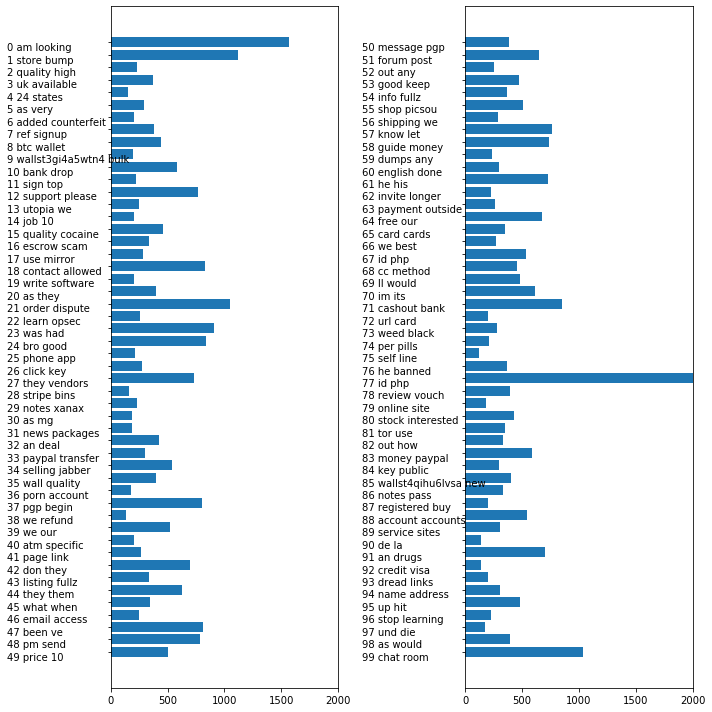

In [13]:
# Evaluate each topics (components) overall weight.
# Topics are name by the two most common words.

topics_per_plot = int(n_topics / 2)
barh_xlim = 2000
plot_pad = 100
fig, ax = plt.subplots(1, 2, figsize=(10, 10))

topic_names = ['{} {}'.format(i, ' '.join(words)) for i, words in enumerate(feat_names[sorted_components[:, :2]])]

for col in [0, 1]:
    start = col * topics_per_plot
    end = (col + 1) * topics_per_plot
    plot_width = np.sum(doc_topics, axis=0)[start:end]
    ax[col].barh(np.arange(topics_per_plot), plot_width)
    ax[col].set_yticks(np.arange(topics_per_plot))
    ax[col].set_yticklabels(topic_names[start:end], ha='left', va='top')
    ax[col].invert_yaxis()
    ax[col].set_xlim(0, barh_xlim)
    y_ax = ax[col].get_yaxis()
    y_ax.set_tick_params(pad=plot_pad)

plt.tight_layout();